In [1]:
import myutil as mu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset  # 텐서데이터셋
from torch.utils.data import DataLoader  # 데이터로더
from torch.utils.data import Dataset
import matplotlib.pyplot as plt  # 맷플롯립사용
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
from sklearn.datasets import load_digits



--- 
 - 깊은 CNN으로 MNIST 분류하기 
   - 이번 챕터에서는 앞서 배운 CNN에 층을 더 추가하여 MNIST를 분류해보겠습니다. 
   - 우리가 만들 모델의 아키텍처를 이해해봅시다. 
   - 모델의 아키텍처는 총 5개의 층으로 구성됩니다. 
   - 앞서 배운 챕터에서 1번 레이어와 2번 레이어는 동일하되, 새로운 합성곱층과 전결합층을 추가했습니다. 
   - 사실 이번 챕터의 코드는 이전 챕터에서 층이 조금 더 추가되는 것 말고는 동일합니다. 


In [2]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)



--- 
 학습에 사용할 파라미터를 설정합니다. 


In [3]:


learning_rate = 0.001
training_epochs = 15
batch_size = 100



--- 
 데이터로더를 사용하여 데이터를 다루기 위해서 데이터셋을 정의해줍니다. 


In [4]:


mnist_train = dsets.MNIST(root='MNIST_data/',  # 다운로드 경로 지정
                          train=True,  # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(),  # 텐서로 변환
                          download=True)

mu.log("mnist_train", mnist_train)

mnist_test = dsets.MNIST(root='MNIST_data/',  # 다운로드 경로 지정
                         train=False,  # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(),  # 텐서로 변환
                         download=True)

mu.log("mnist_test", mnist_test)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

mu.log("len(data_loader)", len(data_loader))
mu.log("data_loader.sampler.num_samples", data_loader.sampler.num_samples)
mu.log("data_loader.batch_size", data_loader.batch_size)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_probe = 0.5

        # (?=데이타갯, 28=width, 28=height, 1=채널수)

        self.layer1 = nn.Sequential(
            # 패딩 1을 줘서 width, height 변화가 없음
            # out_channels를 32로 늘려서 채널수가 증폭되었음.
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            # (?, 28, 28, 32)

            # ReLU는 shape에 영향없음.
            nn.ReLU(),
            # (?, 28, 28, 32)

            # MaxPool(kernel_size=2, stride=2)을 통해서 width, height가 절반으로 줄었음.
            nn.MaxPool2d(kernel_size=2, stride=2)
            # (?, 14, 14, 32)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # (?, 14, 14, 64)

            nn.ReLU(),
            # (?, 14, 14, 64)

            nn.MaxPool2d(kernel_size=2, stride=2)
            # (?, 7, 7, 32)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # (?, 7, 7, 128)

            nn.ReLU(),
            # (?, 7, 7, 128)

            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            # (?, 4, 4, 128)
        )

        # layer3까지의 이미지를 flatten 한 결과
        # 즉 (?, 4, 4, 128) -> (?, -1) -> (?, 4 * 4 * 128)
        self.fc1 = nn.Linear(4 * 4 * 128, 625, bias=True)

        # fc1 값들을 xavier 초기화
        nn.init.xavier_uniform_(self.fc1.weight)

        self.layer4 = nn.Sequential(
            self.fc1,
            # (?, 625)

            nn.ReLU(),
            # (?, 625)

            nn.Dropout(p=1 - self.keep_probe)
        )

        self.fc2 = nn.Linear(625, 10, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)

        self.layer5 = nn.Sequential(
            self.fc2
            # (?, 10)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        data_count = out.size(0)
        out = out.view(data_count, -1)
        out = self.layer4(out)
        out = self.layer5(out)
        return out





mnist_train : 
    Dataset MNIST
        Number of datapoints: 60000
        Root location: MNIST_data/
        Split: Train
        StandardTransform
    Transform: ToTensor()

mnist_test : 
    Dataset MNIST
        Number of datapoints: 10000
        Root location: MNIST_data/
        Split: Test
        StandardTransform
    Transform: ToTensor()

len(data_loader) : 600
data_loader.sampler.num_samples : 60000
data_loader.batch_size : 100


--- 
 모델을 정의합니다. 


In [5]:
model = CNN().to(device)
mu.log("model", model)




model : 
    CNN(
      (layer1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (layer2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (layer3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (fc1): Linear(in_features=2048, out_features=625, bias=True)
      (layer4): Sequential(
        (0): Linear(in_features=2048, out_features=625, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
      )
      (fc2): Linear(in_features=625, out_features=10, bias=True)
      (layer5)

--- 
 비용 함수와 옵티마이저를 정의합니다. 


In [6]:
criterion = nn.CrossEntropyLoss().to(device)
mu.log("criterion", criterion)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mu.log("optimizer", optimizer)



criterion : 
    CrossEntropyLoss() 

optimizer : 
    Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        lr: 0.001
        weight_decay: 0
    )



--- 
 총 배치의 수를 출력해보겠습니다. 


In [7]:
total_batch = len(data_loader)
mu.log("total_batch", total_batch)



total_batch : 600


--- 
 - 총 배치의 수는 600입니다. 
 - 그런데 배치 크기를 100으로 했으므로 결국 훈련 데이터는 총 60,000개란 의미입니다. 
 - 이제 모델을 훈련시켜보겠습니다. 
 - (시간이 꽤 오래 걸립니다.) 


-------------------------------------------------------------------------------- 
epoch :    0/15 
cost : 0.188685 

-------------------------------------------------------------------------------- 
epoch :    1/15 
cost : 0.051825 

-------------------------------------------------------------------------------- 
epoch :    2/15 
cost : 0.037789 

-------------------------------------------------------------------------------- 
epoch :    3/15 
cost : 0.029001 

-------------------------------------------------------------------------------- 
epoch :    4/15 
cost : 0.025091 

-------------------------------------------------------------------------------- 
epoch :    5/15 
cost : 0.019415 

-------------------------------------------------------------------------------- 
epoch :    6/15 
cost : 0.017112 

-------------------------------------------------------------------------------- 
epoch :    7/15 
cost : 0.015958 

----------------------------------------------------------------

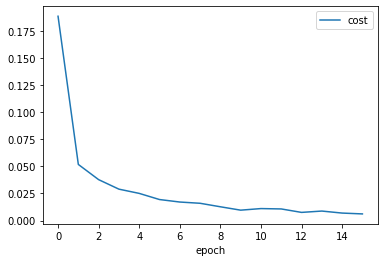

In [8]:
mu.plt_init()

for epoch in range(training_epochs + 1):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        hypothesis = model(X)
        cost = criterion(hypothesis, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    mu.log_epoch(epoch, training_epochs, avg_cost)

mu.plt_show()



--- 
 - 이제 테스트를 해보겠습니다. 
   - 층을 더 깊게 쌓았는데 오히려 정확도가 줄어드는 것을 볼 수 있습니다. 
   - 결국 층을 깊게 쌓는 것도 중요하지만, 꼭 깊게 쌓는 것이 정확도를 올려주지는 않으며 효율적으로 쌓는 것도 중요하다는 의미입니다. 


In [9]:

# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    mu.log("accuracy", accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")



accuracy : 
    torch.Size([]) 0.9850999712944031

